In [1]:

from utils.utils import Utils as ut
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, MobileNetV2, ResNet50
from sklearn.metrics import confusion_matrix, classification_report
from keras.metrics import AUC
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Flatten, LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.initializers import GlorotUniform
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
import io

In [2]:
labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
testing_dir = 'Testing/'
training_dir = 'Training/'

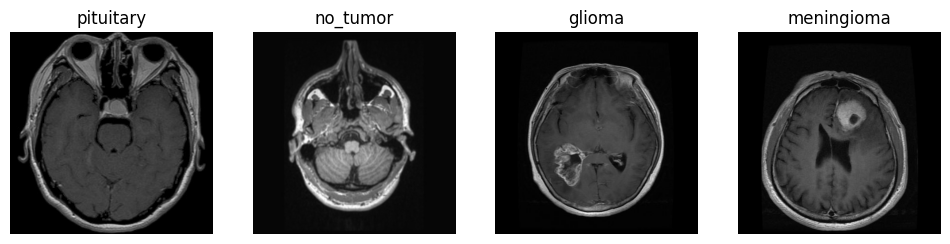

In [3]:
subfolders = ut.get_subfolders(training_dir)
ut.display_images_from_subfolders(training_dir, subfolders)

In [4]:
X_train, y_train = ut.load_data(training_dir, labels)
X_test, y_test = ut.load_data(testing_dir, labels)

In [5]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

y_train = to_categorical(y_train) # One-hot encoding of integer labels
y_test = to_categorical(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) # 20% of the data is validation data

In [6]:
image_gen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
)

image_gen.fit(X_train)

In [ ]:
models_dict = {
    'EfficientNet': ut.build_and_compile_model('EfficientNet', 224),
    'DenseNet': ut.build_and_compile_model('DenseNet', 224),
    'MobileNet': ut.build_and_compile_model('MobileNet', 224),
    'ResNet50': ut.build_and_compile_model('ResNet50', 224)
}

ut.display_summaries(models_dict)

In [ ]:
history_dict = ut.train_models(models_dict)

In [ ]:
for model_name, history in history_dict.items():
    ut.plot('loss', history)
    ut.plot('accuracy', history)
    ut.plot('auc', history)

In [ ]:
for model_name, model in models_dict.items():
    predicted_classes = np.argmax(model.predict(X_test), axis=1)
    confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
    plt.figure(figsize = (16, 16))
    sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True)

    print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [ ]:
metrics_list = []

for model_name, model in models_dict.items():
    loss, acc, auc = model.evaluate(X_test, y_test)
    metrics_list.append([model_name, f"{acc * 100:.2f}%", f"{auc * 100:.2f}%", f"{loss:.2f}"])

df = pd.DataFrame(metrics_list, columns=["Model", "Accuracy (%)", "AUC (%)", "Loss"])

print(df)

In [9]:
model = Sequential([
    # First convolutional layer, note the specification of shape
    # the default activation function here is linear (i.e. no activation).
    # The input shape is the desired size of the image 224x224 with 3 bytes color
    # This is the first convolution, using the 'he_normal' initializer
    Conv2D(32, (3, 3), kernel_initializer='he_normal', input_shape=(224, 224, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    
    Dense(4, activation='softmax', kernel_regularizer=l2(0.01)) # Last layer with one output per class, using sigmoid activation
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 64)     

In [11]:
model = ut.train_model('Custom CNN', image_gen, X_train, y_train, X_val, y_val, model)

Epoch 1/10
160/160 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.8333 - auc: 0.9666
Epoch 1: val_loss improved from inf to 0.76947, saving model to Custom CNN.h5
160/160 [==============================] - 204s 1s/step - loss: 0.4911 - accuracy: 0.8333 - auc: 0.9666 - val_loss: 0.7695 - val_accuracy: 0.7181 - val_auc: 0.9136 - lr: 0.0010
Epoch 2/10
160/160 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.8453 - auc: 0.9716
Epoch 2: val_loss improved from 0.76947 to 0.45740, saving model to Custom CNN.h5
160/160 [==============================] - 202s 1s/step - loss: 0.4535 - accuracy: 0.8453 - auc: 0.9716 - val_loss: 0.4574 - val_accuracy: 0.8504 - val_auc: 0.9699 - lr: 0.0010
Epoch 3/10
160/160 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8664 - auc: 0.9770
Epoch 3: val_loss did not improve from 0.45740
160/160 [==============================] - 210s 1s/step - loss: 0.4132 - accuracy: 0.8664 - auc: 0.9770 - val